In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.layers import Input, ZeroPadding2D, Dense, Dropout, Activation, Conv2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


import numpy as np
import os
import random
import cv2
import math
import seaborn as sns
from tensorflow.keras.utils import to_categorical

2024-06-02 09:30:11.297778: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 09:30:11.297883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 09:30:11.409378: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
def densenet121_model(img_rows, img_cols, color_type=1, nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.5, dropout_rate=0.0, weight_decay=1e-4, num_classes=None):
    '''
    DenseNet 121 Model for Keras based on
    https://github.com/flyyufelix/DenseNet-Keras and updated for current TensorFlow Keras API.
    Returns:
        A Keras model instance.
    '''

    img_input = Input(shape=(img_rows, img_cols, color_type), name='data')
    concat_axis = -1  # Channel last

    nb_layers = [6, 12, 24, 16]  # For DenseNet-121

    # Initial convolution
    x = Conv2D(nb_filter, (7, 7), strides=(2, 2), padding='same', use_bias=False, name='conv1')(img_input)
    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Add dense blocks and transition blocks
    for block_idx in range(nb_dense_block - 1):
        x, nb_filter = dense_block(x=x, nb_layers=nb_layers[block_idx], growth_rate=growth_rate, nb_filter=nb_filter, dropout_rate=dropout_rate, grow_nb_filters=True)
        x = transition_block(x, nb_filter, compression=reduction, dropout_rate=dropout_rate)
        nb_filter = int(nb_filter * reduction)  # Adjust filter count for next block

    # Last dense block does not have a transition block
    x, nb_filter = dense_block(x=x, nb_layers=nb_layers[-1], growth_rate=growth_rate, nb_filter=nb_filter, dropout_rate=dropout_rate, grow_nb_filters=True)

    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(img_input, x)

   # Use legacy version of the SGD optimizer
    # Use the standard version of the SGD optimizer without decay
    sgd = SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [9]:
def conv_block(x, growth_rate, dropout_rate=None):
    '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and optional dropout'''

    # 1x1 Convolution (Bottleneck layer)
    inter_channel = growth_rate * 4
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(inter_channel, (1, 1), use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(growth_rate, (3, 3), use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x

def transition_block(x, nb_filter, compression=1.0, dropout_rate=None):
    ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout'''

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(nb_filter * compression), (1, 1), use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2))(x)

    return x

def dense_block(x, nb_layers, growth_rate,nb_filter, dropout_rate=None, grow_nb_filters=True):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones '''

    for i in range(nb_layers):
        cb = conv_block(x, growth_rate, dropout_rate)
        x = Concatenate()([x, cb])  # Merging feature maps from the input and the new block

        if grow_nb_filters:
            nb_filter += growth_rate

    return x, nb_filter


In [10]:
def load_data(base_path):
    def process_images(directory):
        data = []
        labels = []
        # List all sub-directories in the base directory
        categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
        
        for category in categories:
            path = os.path.join(directory, category)
            images = os.listdir(path)
            for img in images:
                img_path = os.path.join(path, img)
                image = cv2.imread(img_path)
                image = cv2.resize(image, (224, 224))
                image = img_to_array(image)
                data.append(image)
                labels.append(category)
        
        return np.array(data, dtype="float32") / 255.0, np.array(labels)

    train_dir = os.path.join(base_path, 'Training')
    test_dir = os.path.join(base_path, 'Testing')

    # Load training and test data
    xtrain, ytrain = process_images(train_dir)
    xtest, ytest = process_images(test_dir)

    # Encode labels to one-hot
    lb = LabelBinarizer()
    ytrain = lb.fit_transform(ytrain)
    ytest = lb.transform(ytest)  # Use the same fit to transform test labels

    return xtrain, ytrain, xtest, ytest


In [6]:
# Load data
xtrain, ytrain, xtest, ytest = load_data('/kaggle/input/brain-tumor-classification-mri')

In [18]:
img_rows, img_cols = 224, 224  # Resolution of inputs
channel = 3 # means color image
num_classes = 4
batch_size = 32 # means how many images will be pro cessed in one iteration
nb_epoch = 50 # 30 minutes

# Séparer les données d'entraînement en données d'entraînement et de validation
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(xtrain, ytrain, batch_size=batch_size)

model = densenet121_model(img_rows=img_rows, img_cols=img_cols, color_type=channel, num_classes=num_classes)

#Model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
filepath = "densenet121_vrai.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# List of callbacks
callbacks_list = [checkpoint]

# Fit the model
model.fit(train_generator, epochs=nb_epoch, verbose=1, callbacks=callbacks_list, validation_data=(xval, yval))


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4621 - loss: 1.1803
Epoch 1: val_accuracy improved from -inf to 0.27178, saving model to densenet121_vrai.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.4630 - loss: 1.1791 - val_accuracy: 0.2718 - val_loss: 1.3774
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.6165 - loss: 0.9450
Epoch 2: val_accuracy did not improve from 0.27178
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 311ms/step - accuracy: 0.6166 - loss: 0.9448 - val_accuracy: 0.2718 - val_loss: 1.7881
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6725 - loss: 0.8571
Epoch 3: val_accuracy improved from 0.27178 to 0.27352, saving model to densenet121_vrai.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 329ms/step - accuracy: 0.6728 - loss: 0.8565 - val_accuracy: 0.2735 - val_loss: 3.8698
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7171 - loss: 0.7189
Epoch 4: val_accuracy improved from 0.27352 to 0.28397, saving model to densenet

In [19]:
# Charger les meilleurs poids après l'entraînement
model.load_weights('/kaggle/working/densenet121_vrai.keras')

In [27]:
preds = model.predict(xtest, batch_size=batch_size, verbose=1)

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Calculer et afficher la matrice de confusion
ypred_classes = np.argmax(preds, axis=1)
ytest_classes = np.argmax(ytest, axis=1)
cm = confusion_matrix(ytest_classes, ypred_classes)
cm

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


array([[ 23,  18,  58,   1],
       [  1,  74,  38,   2],
       [  2,   2, 101,   0],
       [  6,  11,  31,  26]])

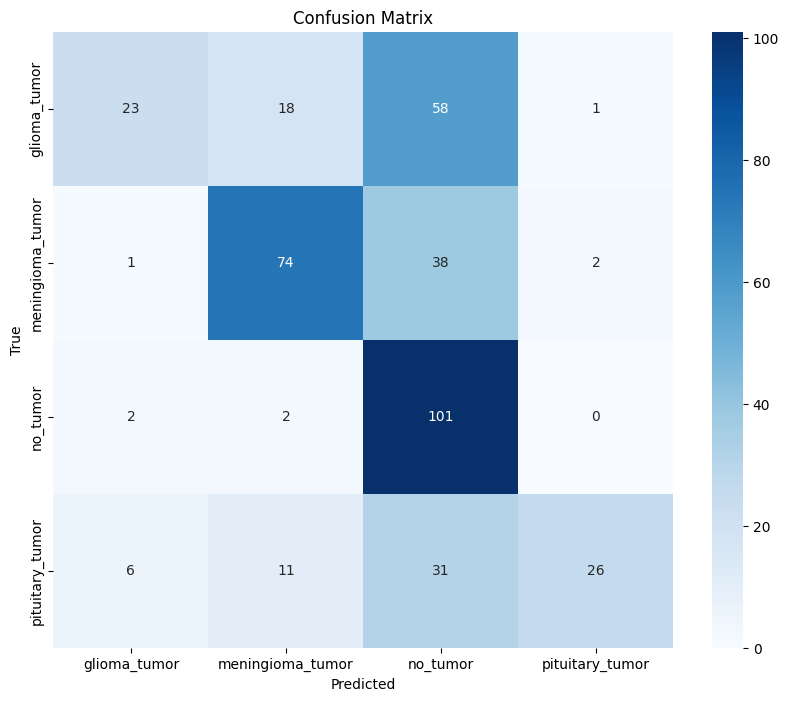

                  precision    recall  f1-score   support

    glioma_tumor       0.72      0.23      0.35       100
meningioma_tumor       0.70      0.64      0.67       115
        no_tumor       0.44      0.96      0.61       105
 pituitary_tumor       0.90      0.35      0.50        74

        accuracy                           0.57       394
       macro avg       0.69      0.55      0.53       394
    weighted avg       0.67      0.57      0.54       394



In [28]:
# Afficher la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'], yticklabels=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Afficher le rapport de classification
print(classification_report(ytest_classes, ypred_classes, target_names=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']))

In [30]:
from sklearn.metrics import accuracy_score
# Calculer la précision globale
accuracy = accuracy_score(ytest_classes, ypred_classes)
print(f'Global accuracy: {accuracy:.2f}')

Global accuracy: 0.57


In [ ]:
#  make predictions on the testing data
preds = model.predict(xtest, batch_size=batch_size, verbose=1)

# score cross-entropy loss
score = log_loss(ytest, preds)
score

In [ ]:

ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

In [ ]:
import matplotlib.pyplot as plt
label=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

In [ ]:
label=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
imidx = random.sample(wrongindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()